In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./tt/train.csv')

In [3]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked']]

In [5]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


In [6]:
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [7]:
data['Cabin'] = pd.factorize(data.Cabin)[0]

In [8]:
data.fillna(0, inplace = True)

In [9]:
data['Sex'] = [1 if x=='male' else 0 for x in data.Sex]

In [10]:
data['p1'] = np.array(data['Pclass'] ==1).astype(np.int32)
data['p2'] = np.array(data['Pclass'] ==2).astype(np.int32)
data['p3'] = np.array(data['Pclass'] ==3).astype(np.int32)

In [11]:
del data['Pclass']

In [12]:
data.Embarked.unique()

array(['S', 'C', 'Q', 0], dtype=object)

In [13]:
data['e1'] = np.array(data['Embarked'] == 'S').astype(np.int32)
data['e2'] = np.array(data['Embarked'] == 'C').astype(np.int32)
data['e3'] = np.array(data['Embarked'] == 'Q').astype(np.int32)

In [14]:
del data['Embarked']

In [15]:
data.values.dtype

dtype('float64')

In [16]:
data.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'p1', 'p2',
       'p3', 'e1', 'e2', 'e3'],
      dtype='object')

In [17]:
data_train = data[['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'p1', 'p2',
       'p3', 'e1', 'e2', 'e3']]

In [18]:
data_target = data['Survived'].values.reshape(len(data),1)


In [19]:
np.shape(data_train), np.shape(data_target)

((891, 12), (891, 1))

In [20]:
import tensorflow as tf

/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
x = tf.placeholder("float", shape=[None,12])
y = tf.placeholder("float", shape=[None,1])

In [22]:
weight = tf.Variable(tf.random_normal([12,1]))
bias = tf.Variable(tf.random_normal([1]))
output = tf.matmul(x, weight) + bias
pred = tf.cast(tf.sigmoid(output)>0.5, tf.float32)

In [23]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = output))

In [24]:
train_step = tf.train.GradientDescentOptimizer(0.003).minimize(loss)

In [25]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(pred,y), tf.float32))

In [26]:
data_test = pd.read_csv('./tt/test.csv')
data_test = data_test[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked']]
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].mean())
data_test['Cabin'] = pd.factorize(data_test.Cabin)[0]
data_test['Sex'] = [1 if x=='male' else 0 for x in data_test.Sex]
data_test.fillna(0, inplace = True)
data_test['p1'] = np.array(data_test['Pclass'] ==1).astype(np.int32)
data_test['p2'] = np.array(data_test['Pclass'] ==2).astype(np.int32)
data_test['p3'] = np.array(data_test['Pclass'] ==3).astype(np.int32)
data_test['e1'] = np.array(data_test['Embarked'] == 'S').astype(np.int32)
data_test['e2'] = np.array(data_test['Embarked'] == 'C').astype(np.int32)
data_test['e3'] = np.array(data_test['Embarked'] == 'Q').astype(np.int32)
del data_test['Pclass']
del data_test['Embarked']

In [27]:
test_label = pd.read_csv('./tt/gender_submission.csv')
test_label = np.reshape(test_label.Survived.values.astype(np.float32), (418,1))

In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_train = []
train_acc = []
test_acc = []

In [29]:
for i in range(5000):
    index = np.random.permutation(len(data_target))
    data_train = np.array(data_train)[index]
    data_target = np.array(data_target)[index]
    for n in range(len(data_target)//100 + 1):
        batch_xs = data_train[n*100:n*100 + 100]
        batch_ys = data_target[n*100:n*100 + 100]
        sess.run(train_step, feed_dict={x:batch_xs, y:batch_ys})
        if i%1000 == 0:
            loss_temp = sess.run(loss, feed_dict={x:batch_xs, y:batch_ys})
            loss_train.append(loss_temp)
            train_acc_temp = sess.run(accuracy, feed_dict={x:batch_xs, y:batch_ys})
            train_acc.append(train_acc_temp)
            test_acc_temp = sess.run(accuracy, feed_dict={x:data_test, y:test_label})
            test_acc.append(test_acc_temp)
            print(loss_temp, train_acc_temp, test_acc_temp)

7.3604326 0.57 0.5717703
8.014492 0.44 0.45454547
7.1409583 0.31 0.4617225
5.1470814 0.36 0.43301436
6.3511767 0.45 0.4784689
5.792799 0.44 0.47368422
4.681352 0.4 0.44258374
5.842095 0.39 0.46411484
3.0389767 0.48351648 0.42105263
0.48493686 0.75 0.8779904
0.4163903 0.79 0.8732057
0.4867239 0.78 0.88755983
0.44354805 0.82 0.88755983
0.52813506 0.76 0.8755981
0.4696804 0.76 0.8851675
0.49193314 0.77 0.8779904
0.45960158 0.83 0.8755981
0.32401434 0.8681319 0.83732057
0.44543365 0.79 0.9114832
0.44734138 0.78 0.8971292
0.4601239 0.8 0.8971292
0.4851056 0.79 0.90430623
0.4117188 0.83 0.8995215
0.39182335 0.78 0.8827751
0.36042503 0.86 0.8923445
0.5273975 0.77 0.8827751
0.4674853 0.8021978 0.8899522
0.3866866 0.87 0.8684211
0.46905473 0.79 0.8947368
0.39205357 0.83 0.94736844
0.52698064 0.78 0.94736844
0.45487815 0.83 0.9569378
0.51008093 0.76 0.9521531
0.36122188 0.85 0.9569378
0.38313925 0.84 0.9186603
0.46178767 0.7582418 0.8779904
0.4290183 0.79 0.90909094
0.38088027 0.86 0.94258374
0.

In [30]:
sess.run(weight)

array([[-2.7579787 ],
       [-0.02792009],
       [-0.33448917],
       [-0.16113752],
       [ 0.01580716],
       [ 0.01695831],
       [ 0.94773066],
       [ 1.2085476 ],
       [ 0.1693252 ],
       [-0.52223164],
       [ 0.05860335],
       [-0.6202243 ]], dtype=float32)

In [31]:
sess.run(bias)

array([1.7377106], dtype=float32)

In [32]:
import matplotlib.pyplot as plt

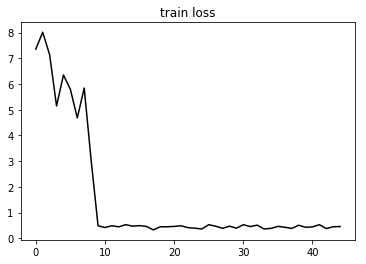

In [33]:
plt.plot(loss_train, 'k-')
plt.title('train loss')
plt.show()

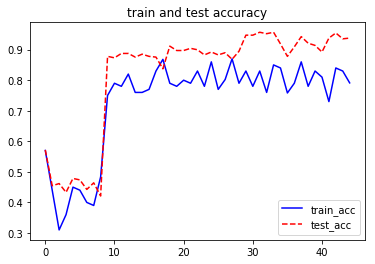

In [34]:
plt.plot(train_acc,'b-', label ='train_acc')
plt.plot(test_acc, 'r--', label = 'test_acc')
plt.title('train and test accuracy')
plt.legend()
plt.show()